# 逻辑回归实现鸢尾花二分类实验

## 实验介绍

逻辑回归（Logistic Regression）是机器学习最经典的算法之一，与线性回归有很多不同，这两种回归都属于广义线性回归（Generalized Linear Regression）的范畴。逻辑回归具有如下特点：

- 逻辑回归对自变量分布没有要求；
- 因变量是离散型变量，即分类变量；
- 逻辑回归分析的是因变量取某个值的概率与自变量的关系。

本实验主要介绍使用MindSpore在2分类数据集上进行逻辑回归实验，分析自变量和因变量（概率）之间的关系，即求得一个概率函数。

## 实验目的

- 了解逻辑回归的基本概念；
- 了解如何使用MindSpore进行逻辑回归实验。

## 预备知识

- 熟练使用Python。
- 具备一定的机器学习理论知识，如逻辑回归、损失函数、优化器，训练策略等。
- 了解华为云的基本使用方法，包括[OBS（对象存储）](https://www.huaweicloud.com/product/obs.html)、[ModelArts（AI开发平台）](https://www.huaweicloud.com/product/modelarts.html)、[训练作业](https://support.huaweicloud.com/engineers-modelarts/modelarts_23_0238.html)等功能。华为云官网：https://www.huaweicloud.com
- 了解并熟悉MindSpore AI计算框架，MindSpore官网：https://www.mindspore.cn/

## 实验环境

- MindSpore 1.3.0（MindSpore版本会定期更新，本指导也会定期刷新，与版本配套）；
- 华为云ModelArts（控制台左上角选择“华北-北京四”）：ModelArts是华为云提供的面向开发者的一站式AI开发平台，集成了昇腾AI处理器资源池，用户可以在该平台下体验MindSpore。

## 实验步骤

### 步骤 1	数据准备
#### 下载数据
Iris数据集是模式识别最著名的数据集之一。数据集包含3类，每类50个实例，其中每个类都涉及一种鸢尾植物。 第一类与后两类可线性分离，后两类之间不能线性分离，所以本实验取前两类数据，做一个2分类数据集。  
  Iris数据集的官网：[Iris Data Set](http://archive.ics.uci.edu/ml/datasets/Iris)。  
方式一，从Iris数据集官网下载[iris.data文件](http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data)。  
方式二，从华为云OBS中下载[iris.data文件](https://share-course.obs.cn-north-4.myhuaweicloud.com/dataset/iris.data)。

每个样本含有4个数值属性和一个类别属性：
1. sepal length in cm
2. sepal width in cm
3. petal length in cm
4. petal width in cm
5. class: 
    - Iris Setosa
    - Iris Versicolour
    - Iris Virginica

概括统计：

                 Min  Max   Mean    SD   Class Correlation
   sepal length: 4.3  7.9   5.84  0.83    0.7826   
    sepal width: 2.0  4.4   3.05  0.43   -0.4194
   petal length: 1.0  6.9   3.76  1.76    0.9490  (high!)
    petal width: 0.1  2.5   1.20  0.76    0.9565  (high!)
#### 上传数据到OBS
点击新建的OBS桶名，通过“上传”、“新建文件夹”等功能，将数据集上传到OBS桶中。

### 步骤二 数据读取与处理
#### 导入MindSpore模块和辅助模块


In [1]:
%matplotlib inline
import os
# os.environ['DEVICE_ID'] = '6'
import csv
import numpy as np

import mindspore as ms
from mindspore import nn
from mindspore import context
from mindspore import dataset
from mindspore.train.callback import LossMonitor
from mindspore.common.api import ms_function
from mindspore.ops import operations as P

context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")

#### 读取Iris数据集，并查看部分数据

In [2]:
with open('iris.data') as csv_file:
    data = list(csv.reader(csv_file, delimiter=','))
print(data[40:60]) # 打印部分数据

[['5.0', '3.5', '1.3', '0.3', 'Iris-setosa'], ['4.5', '2.3', '1.3', '0.3', 'Iris-setosa'], ['4.4', '3.2', '1.3', '0.2', 'Iris-setosa'], ['5.0', '3.5', '1.6', '0.6', 'Iris-setosa'], ['5.1', '3.8', '1.9', '0.4', 'Iris-setosa'], ['4.8', '3.0', '1.4', '0.3', 'Iris-setosa'], ['5.1', '3.8', '1.6', '0.2', 'Iris-setosa'], ['4.6', '3.2', '1.4', '0.2', 'Iris-setosa'], ['5.3', '3.7', '1.5', '0.2', 'Iris-setosa'], ['5.0', '3.3', '1.4', '0.2', 'Iris-setosa'], ['7.0', '3.2', '4.7', '1.4', 'Iris-versicolor'], ['6.4', '3.2', '4.5', '1.5', 'Iris-versicolor'], ['6.9', '3.1', '4.9', '1.5', 'Iris-versicolor'], ['5.5', '2.3', '4.0', '1.3', 'Iris-versicolor'], ['6.5', '2.8', '4.6', '1.5', 'Iris-versicolor'], ['5.7', '2.8', '4.5', '1.3', 'Iris-versicolor'], ['6.3', '3.3', '4.7', '1.6', 'Iris-versicolor'], ['4.9', '2.4', '3.3', '1.0', 'Iris-versicolor'], ['6.6', '2.9', '4.6', '1.3', 'Iris-versicolor'], ['5.2', '2.7', '3.9', '1.4', 'Iris-versicolor']]


#### 抽取样本
取前两类样本（共100条），将数据集的4个属性作为自变量X。将数据集的2个类别映射为{0, 1}，作为因变量Y。


In [3]:
label_map = {
    'Iris-setosa': 0,
    'Iris-versicolor': 1,
}

X = np.array([[float(x) for x in s[:-1]] for s in data[:100]], np.float32)
Y = np.array([[label_map[s[-1]]] for s in data[:100]], np.float32)

#### 样本可视化
取样本的前两个属性进行2维可视化，可以看到在前两个属性上两类样本是线性可分的。


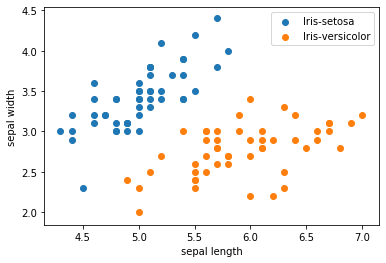

In [4]:
from matplotlib import pyplot as plt
plt.scatter(X[:50, 0], X[:50, 1], label='Iris-setosa')
plt.scatter(X[50:, 0], X[50:, 1], label='Iris-versicolor')
plt.xlabel('sepal length')
plt.ylabel('sepal width')
plt.legend()

#### 分割数据集
将数据集按8:2划分为训练集和验证集：


In [5]:
train_idx = np.random.choice(100, 80, replace=False)
test_idx = np.array(list(set(range(100)) - set(train_idx)))
X_train, Y_train = X[train_idx], Y[train_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

In [6]:
# def normalize(data):
#     v_max = np.max(data, axis=0)
#     v_min = np.min(data, axis=0)
#     return np.divide(data - v_min, v_max - v_min) * 2.0 - 1.0
# train_data = list(zip(normalize(X_train), Y_train))

#### 数据类型转换
使用MindSpore的GeneratorDataset接口将numpy.ndarray类型的数据转换为Dataset：


In [7]:
XY_train = list(zip(X_train, Y_train))
ds_train = dataset.GeneratorDataset(XY_train, ['x', 'y'])
#ds_train.set_dataset_size(80)
ds_train = ds_train.shuffle(buffer_size=80).batch(32, drop_remainder=True)

In [8]:
#help(ds_train)#ds_train.get_dataset_size()

### 步骤三 模型建立与训练
#### 可视化逻辑回归函数
逻辑回归常用的联系函数是Sigmoid（S形函数），Sigmoid函数如下图所示，可以将连续值映射到{0, 1}，同时也是单调可微的。


In [9]:
coor_x = np.arange(-10, 11, dtype=np.float32)
coor_y = nn.Sigmoid()(ms.Tensor(coor_x)).asnumpy()
plt.plot(coor_x, coor_y)
plt.xlabel('x')
plt.ylabel('p')

[CRITICAL] DEVICE(40732,ffff9e036780,python):2023-01-06-15:40:08.649.474 [mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_memory_adapter.cc:60] Initialize] Malloc device memory failed, free memory size is less than half of total memory size.Device 0 Device HBM total size:34359738368 Device HBM free size:2078674944 may be other processes occupying this card, check as: ps -ef|grep python


RuntimeError: mindspore/ccsrc/plugin/device/ascend/hal/device/ascend_memory_adapter.cc:60 Initialize] Malloc device memory failed, free memory size is less than half of total memory size.Device 0 Device HBM total size:34359738368 Device HBM free size:2078674944 may be other processes occupying this card, check as: ps -ef|grep python

####  建模
使用MindSpore提供的[`nn.Dense(4, 1)`算子](https://www.mindspore.cn/api/zh-CN/0.2.0-alpha/api/python/mindspore/mindspore.nn.html#mindspore.nn.Dense)作为线性部分，其中`(4, 1)`表示每个样本的输入是含4个元素的向量，输出是含1个元素的向量，即$W$是1x4的矩阵。算子会随机初始化权重$W$和偏置$b$。使用[`SigmoidCrossEntropyWithLogits`算子](https://www.mindspore.cn/api/zh-CN/0.3.0-alpha/api/python/mindspore/mindspore.ops.operations.html?#mindspore.ops.operations.SigmoidCrossEntropyWithLogits)作为非线性部分：

对于每个样本$N_i$，模型的计算方式如下：

$$
Z_i = W \cdot X_i + b \\
P_{i} = sigmoid(Z_{i}) = \frac{1}{1 + e^{-Z_{i}}} \\
loss = -\frac{1}n\sum_i[Y_{i} * ln(P_{i}) + (1 - Y_{i})ln(1 - P_{i})]
$$

其中，$X_i$是1D Tensor（含4个元素），$Z_i$是1D Tensor（含1个元素），$Y_i$是真实类别（2个类别{0, 1}中的一个），$P_i$是1D Tensor（含1个元素，表示属于类别1的概率，值域为[0, 1]），$loss$是标量。


In [ ]:
# 自定义Loss
class Loss(nn.Cell):
    def __init__(self):
        super(Loss, self).__init__()
        self.sigmoid_cross_entropy_with_logits = P.SigmoidCrossEntropyWithLogits()
        self.reduce_mean = P.ReduceMean(keep_dims=False)
    def construct(self, x, y):
        loss = self.sigmoid_cross_entropy_with_logits(x, y)
        return self.reduce_mean(loss, -1)

net = nn.Dense(4, 1)
loss = Loss()
opt = nn.optim.SGD(net.trainable_params(), learning_rate=0.003)

#### 模型训练
使用2分类的Iris数据集对模型进行几代（Epoch）训练

In [ ]:
model = ms.train.Model(net, loss, opt)
model.train(5, ds_train, callbacks=[LossMonitor(per_print_times=ds_train.get_dataset_size())], dataset_sink_mode=False)

### 步骤四 模型评估
然后计算模型在测试集上精度，测试集上的精度达到了1.0左右，即逻辑回归模型学会了区分2类鸢尾花。


In [ ]:
x = model.predict(ms.Tensor(X_test)).asnumpy()
pred = np.round(1 / (1 + np.exp(-x)))
correct = np.equal(pred, Y_test)
acc = np.mean(correct)
print('Test accuracy is', acc)

## 实验小结
本实验使用MindSpore实现了逻辑回归，用来解决2分类问题。在Iris数据集上进行训练后，所得的模型可以很好的表示每个样本类别y和属性x的关系。

## 创新设计
请使用Softmax函数作为联系函数，对完整的Iris数据集实现多分类任务。
